Author: Micheal C. Chen

Contact: muchuchen03@gmail.com

## Task 1
In this task, we will utilize traditional finite-system density matrix renormalization group (DMRG) to calculate properties of the **XY model** .
$$
H \;=\; -\sum_{i=1}^{N-1}\!\Big(\sigma_i^x \sigma_{i+1}^x + g\,\sigma_i^y \sigma_{i+1}^y\Big).
$$

Use the parameters:
- N = 40.
- Fix $m=10$, sweep $g\in\{0.5,\,1.0,\,1.5\}$.
- Fix $g=1.0$, sweep $m\in\{10,\,20,\,30\}$.
## Tasks
1. Explicitly show the data of ground state energy and entanglement entropy $S(L)$.
2. Plot the entanglement entropy $S(L)$ as a function of $L$, $S(L)=-\mathrm{Tr}[\rho_L \ln \rho_L]$.
3. Use $N=40,\; g=1.0,\; m=20$ to fit $S(L)$ and extract central charge $c$ using $S(L) = \cfrac{c}{6}\ln\left(\cfrac{N}{\pi}\sin\cfrac{\pi L}{N}\right) + c'$.

The program references the [open-source **simple-dmrg** tutorial](https://github.com/simple-dmrg/simple-dmrg) (MIT license) by Garrison & Mishmash.

In [1]:
from __future__ import print_function, division  # requires Python >= 2.6

import numpy as np
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh  # Lanczos routine from ARPACK
from collections import namedtuple

In [2]:
Block = namedtuple("Block", ["length", "basis_size", "operator_dict"])
EnlargedBlock = namedtuple("EnlargedBlock", ["length", "basis_size", "operator_dict"])

def is_valid_block(block):
    for op in block.operator_dict.values():
        if op.shape[0] != block.basis_size or op.shape[1] != block.basis_size:
            return False
    return True
is_valid_enlarged_block = is_valid_block

Define the XY model’s **local operators**, the **two-site coupling**, and a **seed block** carrying the Hamiltonian and edge operators needed to grow the chain.


In [3]:
model_d = 2  # single-site basis size
Sx1 = np.array([[0, 1],
                 [1, 0]], dtype = complex)  # single-site sigma^x
Sy1 = np.array([[0, -1j],
                 [1j, 0]], dtype = complex)  # single-site sigma^y
g = 1

H1 = np.array([[0, 0], [0, 0]], dtype = complex)  # single-site portion of H is zero

def H2(Sx1, Sy1, Sx2, Sy2, g):  # two-site part of H
    return (
        -(kron(Sx1, Sx2) + g * kron(Sy1, Sy2))
    )

initial_block = Block(length=1, basis_size=model_d, operator_dict={
    "H": H1,
    "conn_Sx": Sx1,
    "conn_Sy": Sy1,
})

We grows a DMRG block by one site:
$$
H_{\rm SB}=H^{(L)}\!\otimes I^{(R)}+I^{(L)}\!\otimes H^{(R)}
+H_2\!\big(S_x^{L,\mathrm{edge}},S_y^{L,\mathrm{edge}},S_x^{R,\mathrm{edge}},S_y^{R,\mathrm{edge}};g\big).
$$

And use the isometry $U$ (top-$m$ eigenvectors of $\rho$), operators are updated by
$$
O' = U^\dagger\, O \, U .
$$


In [4]:
def enlarge_block(block, g):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict

    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.

    I_block = identity(mblock, dtype = complex)
    I_site = identity(model_d, dtype = complex)
    enlarged_operator_dict = {
        "H": kron(o["H"], I_site) + kron(I_block, H1) + H2(o["conn_Sx"], o["conn_Sy"], Sx1, Sy1, g),
        "conn_Sx": kron(identity(mblock), Sx1),
        "conn_Sy": kron(identity(mblock), Sy1),
    }

    return EnlargedBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)

def rotate_and_truncate(operator, transformation_matrix):
    """Transforms the operator to the new (possibly truncated) basis given by
    `transformation_matrix`.
    """
    return transformation_matrix.conjugate().transpose().dot(operator.dot(transformation_matrix))

In one DMRG step, the system and environment are enlarged by one site and the superblock Hamiltonian is built,
$$
H_{\rm SB}=H^{(L)}\!\otimes I^{(R)}+I^{(L)}\!\otimes H^{(R)}
+H_2\!\big(S_x^{L,\mathrm{edge}},S_y^{L,\mathrm{edge}},S_x^{R,\mathrm{edge}},S_y^{R,\mathrm{edge}};g\big).
$$
After finding the ground state $|\psi_0 \rangle$, reshape and trace out the environment to obtain
$$
\rho_L=\mathrm{Tr}_R\!\left(|\psi_0\rangle\langle\psi_0|\right),\qquad
S(L)=-\mathrm{Tr}\,\rho_L\ln\rho_L.
$$
Keep the top $m$ eigenvectors of $\rho_L$ to form the isometry $U$ and rotate/truncate all system operators,
$$
O' = U^\dagger O\,U, \qquad
\epsilon_{\rm tr}=1-\sum_{i=1}^{m}\lambda_i,
$$
where $\lambda_i$ are the eigenvalues of $\rho_L$ and $\epsilon_{\rm tr}$ is the truncation error.

In [5]:
def single_dmrg_step(sys, env, m, g):
    """Performs a single DMRG step using `sys` as the system and `env` as the
    environment, keeping a maximum of `m` states in the new basis.
    """
    assert is_valid_block(sys)
    assert is_valid_block(env)

    # Enlarge each block by a single site.
    sys_enl = enlarge_block(sys, g)
    if sys is env:  # no need to recalculate a second time
        env_enl = sys_enl
    else:
        env_enl = enlarge_block(env, g)

    assert is_valid_enlarged_block(sys_enl)
    assert is_valid_enlarged_block(env_enl)

    # Construct the full superblock Hamiltonian.
    m_sys_enl = sys_enl.basis_size
    m_env_enl = env_enl.basis_size
    sys_enl_op = sys_enl.operator_dict
    env_enl_op = env_enl.operator_dict
    I_sys = identity(m_sys_enl, dtype = complex)
    I_env = identity(m_env_enl, dtype = complex)
    superblock_hamiltonian = kron(sys_enl_op["H"], I_env) + kron(I_sys, env_enl_op["H"]) + \
                             H2(sys_enl_op["conn_Sx"], sys_enl_op["conn_Sy"], env_enl_op["conn_Sx"], env_enl_op["conn_Sy"], g)

    # Call ARPACK to find the superblock ground state.  ("SA" means find the
    # "smallest in amplitude" eigenvalue.)
    (energy,), psi0 = eigsh(superblock_hamiltonian, k=1, which="SA")

    # Construct the reduced density matrix of the system by tracing out the
    # environment
    #
    # We want to make the (sys, env) indices correspond to (row, column) of a
    # matrix, respectively.  Since the environment (column) index updates most
    # quickly in our Kronecker product structure, psi0 is thus row-major ("C
    # style").
    psi0 = psi0.reshape([sys_enl.basis_size, -1], order="C")
    rho = np.dot(psi0, psi0.conjugate().transpose())

    # Diagonalize the reduced density matrix and sort the eigenvectors by
    # eigenvalue.
    evals, evecs = np.linalg.eigh(rho)
    possible_eigenstates = []
    for eval, evec in zip(evals, evecs.transpose()):
        possible_eigenstates.append((eval, evec))
    possible_eigenstates.sort(reverse=True, key=lambda x: x[0])  # largest eigenvalue first

    # Build the transformation matrix from the `m` overall most significant
    # eigenvectors.
    my_m = min(len(possible_eigenstates), m)
    transformation_matrix = np.zeros((sys_enl.basis_size, my_m), dtype=complex, order='F')
    for i, (eval, evec) in enumerate(possible_eigenstates[:my_m]):
        transformation_matrix[:, i] = evec

    truncation_error = 1 - sum([x[0] for x in possible_eigenstates[:my_m]])
    # print("truncation error:", truncation_error)

    lamb = evals[evals > 1e-15]
    entropy = float(-np.sum(lamb * np.log(lamb)))
    # Rotate and truncate each operator.
    new_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_operator_dict[name] = rotate_and_truncate(op, transformation_matrix)

    newblock = Block(length=sys_enl.length,
                     basis_size=my_m,
                     operator_dict=new_operator_dict)

    return newblock, float(energy), entropy, float(truncation_error)

Start from a one-site seed block and **grow symmetrically**: at block length $\ell$, build a superblock of size
$$
L_{\rm SB}=2\ell+2,
$$
with Hamiltonian
$$
H_{\rm SB}=H^{(L)}\!\otimes I^{(R)}+I^{(L)}\!\otimes H^{(R)}
+H_2\!\big(S_x^{L,\mathrm{edge}},S_y^{L,\mathrm{edge}},S_x^{R,\mathrm{edge}},S_y^{R,\mathrm{edge}};g\big).
$$

In [6]:
def graphic(sys_block, env_block, sys_label="l"):
    """Returns a graphical representation of the DMRG step we are about to
    perform, using '=' to represent the system sites, '-' to represent the
    environment sites, and '**' to represent the two intermediate sites.
    """
    assert sys_label in ("l", "r")
    graphic = ("=" * sys_block.length) + "**" + ("-" * env_block.length)
    if sys_label == "r":
        # The system should be on the right and the environment should be on
        # the left, so reverse the graphic.
        graphic = graphic[::-1]
    return graphic

def infinite_system_algorithm(L, m, g):
    block = initial_block
    # Repeatedly enlarge the system by performing a single DMRG step, using a
    # reflection of the current block as the environment.
    while 2 * block.length < L:
        print("L =", block.length * 2 + 2)
        block, energy = single_dmrg_step(block, block, m=m, g=g)
        print("E/L =", energy / (block.length * 2))

The procedure first **grows to the target size** $L$ using mirror environments and saves every renormalized block to a lightweight “disk” as $B_{\alpha,\ell}$ with $\alpha\in\{l,r\}$ and current length $\ell$. This warm-up ensures that, for any later bipartition, a compatible partner block is already available.

Once at size $L$, it performs **finite sweeps**. At each micro-step it selects a system block $B_{\alpha,\ell}$ and the matching environment block $B_{\bar\alpha,\,L-\ell-2}$ from disk, enlarges both by one site, builds the superblock Hamiltonian, and computes the ground state $|\psi_0\rangle$. Reshaping and tracing out the environment yields the reduced density matrix $\rho_L=\mathrm{Tr}_R(|\psi_0\rangle\langle\psi_0|)$. Keeping the $m$ largest eigenpairs $\{\lambda_i,|v_i\rangle\}$ defines the isometry $U=[|v_1\rangle,\dots,|v_m\rangle]$, which rotates/truncates all system operators via $O'=U^\dagger O\,U$. The **truncation error** is $\epsilon_{\rm tr}=1-\sum_{i=1}^{m}\lambda_i$, and the **entanglement entropy** at the current cut is $S(L)=-\mathrm{Tr}(\rho_L\ln\rho_L)$. The updated block is written back to disk as $B_{\alpha,\ell+1}$.

The sweep proceeds left→right while the system grows and the environment shrinks; when the environment reaches length $1$, roles are reversed (right→left) and the process continues using the stored blocks on the opposite side. Repeating this for a prescribed list of bond dimensions $\{m\}$ reduces $\epsilon_{\rm tr}$ and stabilizes energies and entropies near the chain center. At the end of the final sweep the algorithm reports the **ground-state energy** for size $L$ and the **entropy series** $\{(L,S(L))\}$ collected along the last pass, with cuts standardized to ascending $L=2,\dots,L-2$ and the symmetry $S(L)=S(N-L)$ used when needed.


In [7]:
def finite_system_algorithm(L, m_warmup, m_sweep_list, g):
    assert L % 2 == 0  # require that L is an even number

    block_disk = {}  # "disk" storage for Block objects
    block = initial_block
    block_disk["l", block.length] = block
    block_disk["r", block.length] = block

    while 2 * block.length < L:
        # Perform a single DMRG step and save the new Block to "disk"
        # print(graphic(block, block))
        block, energy, _, _ = single_dmrg_step(block, block, m=m_warmup, g=g)
        # print("E/L =", energy / (block.length * 2))
        block_disk["l", block.length] = block
        block_disk["r", block.length] = block


    sys_label, env_label = "l", "r"
    sys_block = block; del block  # rename the variable
    last_sweep_records = []
    final_energy = None

    for m in m_sweep_list:
        sweep_records = []
        while True:
            # Load the appropriate environment block from "disk"
            env_block = block_disk[env_label, L - sys_block.length - 2]
            if env_block.length == 1:
                # We've come to the end of the chain, so we reverse course.
                sys_block, env_block = env_block, sys_block
                sys_label, env_label = env_label, sys_label

            # Perform a single DMRG step.
            # print(graphic(sys_block, env_block, sys_label))
            sys_block, energy, S_L, te = single_dmrg_step(sys_block, env_block, m=m, g=g)
            final_energy = energy
            # print("E/L =", energy / L)

            # Save the block from this step to disk.
            block_disk[sys_label, sys_block.length] = sys_block
            sweep_records.append({
                "L": sys_block.length,
                "Energy": float(energy),
                "E/L": float(energy)/L,
                "S(L)": float(S_L),
                "TruncError": float(te),
                "m": m,
                "g": g,
            })
            # Check whether we just completed a full sweep.
            if sys_label == "l" and 2 * sys_block.length == L:
                break  # escape from the "while True" loop
        last_sweep_records = sweep_records
    S_series = [(rec["L"], rec["S(L)"]) for rec in last_sweep_records]
    return float(final_energy), S_series

## Result 1:
Explicitly show the data of ground state energy and entanglement entropy $S(L)$.

In [8]:
N = 40
m_keep = 10
groupA_EE = {} 
last_L_target = None   

for g_val in [0.5, 1.0, 1.5]:
    energy, S_series = finite_system_algorithm(L=N, m_warmup=m_keep, m_sweep_list=[m_keep], g=g_val)

    S_map = {Lval: Sval for (Lval, Sval) in S_series}
    L_target = list(range(2, N-1))
    EE_out = []
    for Lval in L_target:
        if Lval in S_map:
            EE_out.append(S_map[Lval])
        elif (N - Lval) in S_map:
            EE_out.append(S_map[N - Lval])
        else:
            EE_out.append(np.nan)

    print(f"(N, m, g)= ({N}, {m_keep}, {g_val})")
    print(f"Energy: {energy}")
    print("L:", np.array(L_target, dtype=int))
    print("EE:", np.array(EE_out, dtype=float))
    print()

    groupA_EE[f"g={g_val}"] = np.array(EE_out, dtype=float)
    last_L_target = np.array(L_target, dtype=int)

g_fixed = 1.0
groupB_EE = {}

for m_keep in [10, 20, 30]:
    energy, S_series = finite_system_algorithm(L=N, m_warmup=m_keep, m_sweep_list=[m_keep], g=g_fixed)

    S_map = {Lval: Sval for (Lval, Sval) in S_series}
    L_target = list(range(2, N-1))
    EE_out = []
    for Lval in L_target:
        if Lval in S_map:
            EE_out.append(S_map[Lval])
        elif (N - Lval) in S_map:
            EE_out.append(S_map[N - Lval])
        else:
            EE_out.append(np.nan)

    print(f"(N, m, g)= ({N}, {m_keep}, {g_fixed})")
    print(f"Energy: {energy}")
    print("L:", np.array(L_target, dtype=int))
    print("EE:", np.array(EE_out, dtype=float))
    print()

    groupB_EE[f"m={m_keep}"] = np.array(EE_out, dtype=float)
    last_L_target = np.array(L_target, dtype=int)

(N, m, g)= (40, 10, 0.5)
Energy: -41.60529186250394
L: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38]
EE: [0.65370704 0.75425201 0.75321945 0.77602525 0.77693942 0.78244631
 0.78286534 0.78422006 0.7843574  0.78469337 0.78473301 0.78481698
 0.78482741 0.78484879 0.78485108 0.78485688 0.78485692 0.7848588
 0.78485804 0.78485878 0.78485688 0.78485681 0.78485096 0.78484858
 0.78482705 0.78481635 0.78473202 0.78469174 0.7843551  0.78421666
 0.78286163 0.78244212 0.77693692 0.77602516 0.75321945 0.75425201
 0.65370704]

(N, m, g)= (40, 10, 1.0)
Energy: -50.20622591632595
L: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38]
EE: [0.53142371 0.75324226 0.66313381 0.79733779 0.73124754 0.82785176
 0.77305456 0.84904673 0.80052286 0.86382361 0.8190448  0.87404468
 0.83148294 0.88089754 0.83947718 0.88512533 0.8439731  0.88716056
 0.84546178 0.88530493 0.8410667  0.88

## Result 2:
Plot the entanglement entropy $S(L)$ as a function of $L$, $S(L)=-\mathrm{Tr}[\rho_L \ln \rho_L]$.


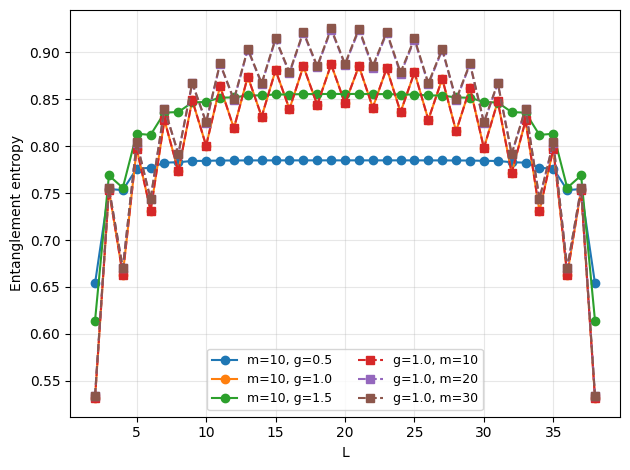

In [9]:
import matplotlib.pyplot as plt
plt.figure()
L_axis = last_L_target

if "g=0.5" in groupA_EE: plt.plot(L_axis, groupA_EE["g=0.5"], marker="o", linestyle="-",  label="m=10, g=0.5")
if "g=1.0" in groupA_EE: plt.plot(L_axis, groupA_EE["g=1.0"], marker="o", linestyle="-",  label="m=10, g=1.0")
if "g=1.5" in groupA_EE: plt.plot(L_axis, groupA_EE["g=1.5"], marker="o", linestyle="-",  label="m=10, g=1.5")

if "m=10" in groupB_EE: plt.plot(L_axis, groupB_EE["m=10"], marker="s", linestyle="--", label="g=1.0, m=10")
if "m=20" in groupB_EE: plt.plot(L_axis, groupB_EE["m=20"], marker="s", linestyle="--", label="g=1.0, m=20")
if "m=30" in groupB_EE: plt.plot(L_axis, groupB_EE["m=30"], marker="s", linestyle="--", label="g=1.0, m=30")

plt.xlabel("L")
plt.ylabel("Entanglement entropy")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()

## Result 3:
Use $N=40,\; g=1.0,\; m=20$ to fit $S(L)$ and extract central charge $c$ using $S(L) = \cfrac{c}{6}\ln\left(\cfrac{N}{\pi}\sin\cfrac{\pi L}{N}\right) + c'$.

Central charge= 1.9130207439750233
intercept= 0.3436063571963685
r_value= 0.667029693431441


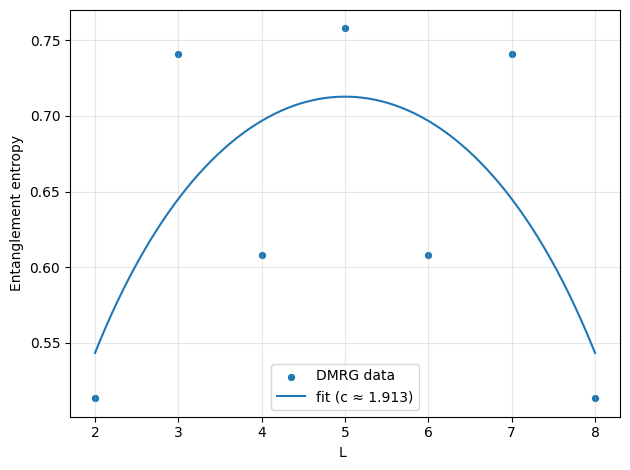

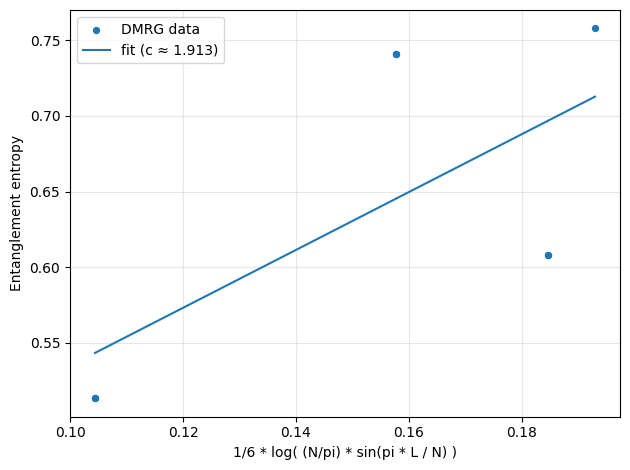

In [10]:
N = 10
g_val = 1.0
m_keep = 20

energy, S_series = finite_system_algorithm(L=N, m_warmup=m_keep, m_sweep_list=[m_keep, m_keep], g=g_val)
S_map = {Lval: Sval for (Lval, Sval) in S_series}
L_list = list(range(2, N-1))
EE = []
for L in L_list:
    if L in S_map:
        EE.append(S_map[L])
    elif (N - L) in S_map:
        EE.append(S_map[N - L])
    else:
        EE.append(np.nan)
EE = np.array(EE, dtype=float)
L_arr = np.array(L_list, dtype=int)

x = np.log((N/np.pi) * np.sin(np.pi * L_arr / N))
y = EE

mask = np.isfinite(x) & np.isfinite(y)
x_fit = x[mask]
y_fit = y[mask]

A = np.vstack([x_fit, np.ones_like(x_fit)]).T
a, b = np.linalg.lstsq(A, y_fit, rcond=None)[0]
c_est = 6.0 * a

r = np.corrcoef(x_fit, y_fit)[0, 1]


print("Central charge=", c_est)
print("intercept=", b)
print("r_value=",r)

# Fig 1
plt.figure()
plt.scatter(L_arr[mask], y_fit, s=18, label="DMRG data")
L_dense = np.linspace(2, N-2, 400)
x_dense = np.log((N/np.pi) * np.sin(np.pi * L_dense / N))
S_dense = a * x_dense + b
plt.plot(L_dense, S_dense, label=f"fit (c ≈ {c_est:.3f})")
plt.xlabel("L ")
plt.ylabel("Entanglement entropy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()


x6 = x / 6.0
plt.figure()
plt.scatter(x6[mask], y_fit, s=18, label="DMRG data")
x6_line = np.linspace(x6[mask].min(), x6[mask].max(), 200)
S_line  = c_est * x6_line + b
plt.plot(x6_line, S_line, label=f"fit (c ≈ {c_est:.3f})")

plt.xlabel("1/6 * log( (N/pi) * sin(pi * L / N) )")
plt.ylabel("Entanglement entropy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()